In [47]:

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ✅ Load and clean data
df = pd.read_csv('../../data/downloads/freight_model_output_20250429_153346.csv')
df = df.drop_duplicates(subset='invoice_id', keep='first')
df.columns

Index(['invoice_id', 'site', 'new_commodity_group',
       'invoice_commodity_quantity', 'multiple_commodities',
       'priority_multiple_commodities', 'freight_per_invoice',
       'standardization_status', 'error_summary', 'priority_failure_reasons',
       'method', 'unit', 'rate_unit', 'freight_class', 'rate', 'shipment_type',
       'invoice_freight_commodity_cost', 'raw_invoice_cost', 'minimum_applied',
       'calibrated_market_freight_costs', 'market_rate', 'xgs_applied_rate',
       'xgs_raw_rate', 'freight_ratio_raw', 'freight_ratio_normal',
       'rate_ratio_raw', 'rate_ratio_normal', 'market_cost_outlier',
       'freight_ratio_raw_outlier', 'freight_ratio_normal_outlier'],
      dtype='object')

In [48]:
vnl = df[df['new_commodity_group'] == '1VNL']
cbl = df[df['new_commodity_group'] == '1CBL']
cpt = df[df['new_commodity_group'] == '1CPT']

In [49]:
# Updated LBS-based simulation (e.g. 1VNL)
def simulate_ftl_thresholds_verbose(data, freight_price_col='calibrated_market_freight_costs', quantity_col='invoice_commodity_quantity', thresholds=[5000,10000, 15000, 20000, 25000]):
    data['invoice_commodity_quantity'] = pd.to_numeric(data[quantity_col], errors='coerce')
    data['calibrated_market_freight_costs'] = pd.to_numeric(data[freight_price_col], errors='coerce')

    results = []

    for threshold in thresholds:
        data['simulated_type'] = data['invoice_commodity_quantity'].apply(lambda q: 'FTL' if q >= threshold else 'LTL')
        data['unit_cost'] = (data['calibrated_market_freight_costs'] / data['invoice_commodity_quantity']).round(2)

        grouped = data.groupby('simulated_type').agg(
            avg_cost_per_lb=('unit_cost', 'mean'),
            shipment_count=('unit_cost', 'count')
        ).reset_index()
        grouped['threshold'] = threshold
        results.append(grouped)

    combined = pd.concat(results)
    pivot = combined.pivot(index='threshold', columns='simulated_type', values=['avg_cost_per_lb', 'shipment_count']).round(3)
    pivot.columns = [f"{metric}_{stype}" for metric, stype in pivot.columns]
    return pivot.reset_index()


In [50]:
# Run simulation on 1VNL
valid_rows = vnl[(vnl['calibrated_market_freight_costs'] > 0) & (vnl['invoice_commodity_quantity'] > 0)]
summary_vnl = simulate_ftl_thresholds_verbose(valid_rows)
display(summary_vnl)


,threshold,avg_cost_per_lb_FTL,avg_cost_per_lb_LTL,shipment_count_FTL,shipment_count_LTL
0,5000,0.074,1.090,387.0,2965.0
1,10000,0.064,1.030,199.0,3153.0
2,15000,0.058,1.009,128.0,3224.0
3,20000,0.053,0.999,95.0,3257.0
4,25000,0.056,0.992,71.0,3281.0


In [51]:
df.columns

Index(['invoice_id', 'site', 'new_commodity_group',
       'invoice_commodity_quantity', 'multiple_commodities',
       'priority_multiple_commodities', 'freight_per_invoice',
       'standardization_status', 'error_summary', 'priority_failure_reasons',
       'method', 'unit', 'rate_unit', 'freight_class', 'rate', 'shipment_type',
       'invoice_freight_commodity_cost', 'raw_invoice_cost', 'minimum_applied',
       'calibrated_market_freight_costs', 'market_rate', 'xgs_applied_rate',
       'xgs_raw_rate', 'freight_ratio_raw', 'freight_ratio_normal',
       'rate_ratio_raw', 'rate_ratio_normal', 'market_cost_outlier',
       'freight_ratio_raw_outlier', 'freight_ratio_normal_outlier'],
      dtype='object')

In [52]:
# Updated SQYD-based simulation (e.g. 1CBL)
def simulate_ftl_thresholds_cbl(data, freight_price_col='calibrated_market_freight_costs', quantity_col='invoice_commodity_quantity', thresholds_in_rolls=[20, 25, 30, 45, 50, 60]):
    thresholds = [rolls * 100 for rolls in thresholds_in_rolls]

    data['invoice_commodity_quantity'] = pd.to_numeric(data[quantity_col], errors='coerce')
    data['calibrated_market_freight_costs'] = pd.to_numeric(data[freight_price_col], errors='coerce')

    results = []

    for threshold, rolls in zip(thresholds, thresholds_in_rolls):
        data['simulated_type'] = data['invoice_commodity_quantity'].apply(lambda q: 'FTL' if q >= threshold else 'LTL')
        data['unit_cost'] = (data['calibrated_market_freight_costs'] / data['invoice_commodity_quantity']).round(2)

        grouped = data.groupby('simulated_type').agg(
            avg_cost_per_sqyd=('unit_cost', 'mean'),
            shipment_count=('unit_cost', 'count')
        ).reset_index()
        grouped['threshold_rolls'] = rolls
        results.append(grouped)

    combined = pd.concat(results)
    pivot = combined.pivot(index='threshold_rolls', columns='simulated_type', values=['avg_cost_per_sqyd', 'shipment_count']).round(3)
    pivot.columns = [f"{metric}_{stype}" for metric, stype in pivot.columns]
    return pivot.reset_index()


In [53]:
# Run simulation on 1CBL
valid_rows = cbl[(cbl['calibrated_market_freight_costs'] > 0) & (cbl['invoice_commodity_quantity'] > 0)]
summary_cbl = simulate_ftl_thresholds_cbl(valid_rows)
display(summary_cbl)


,threshold_rolls,avg_cost_per_sqyd_FTL,avg_cost_per_sqyd_LTL,shipment_count_FTL,shipment_count_LTL
0,20,0.651,1.760,26.0,556.0
1,25,0.474,1.750,18.0,564.0
2,30,0.435,1.747,16.0,566.0
3,45,0.215,1.740,11.0,571.0
4,50,0.151,1.738,10.0,572.0
5,60,0.126,1.733,8.0,574.0


In [54]:
df.columns

Index(['invoice_id', 'site', 'new_commodity_group',
       'invoice_commodity_quantity', 'multiple_commodities',
       'priority_multiple_commodities', 'freight_per_invoice',
       'standardization_status', 'error_summary', 'priority_failure_reasons',
       'method', 'unit', 'rate_unit', 'freight_class', 'rate', 'shipment_type',
       'invoice_freight_commodity_cost', 'raw_invoice_cost', 'minimum_applied',
       'calibrated_market_freight_costs', 'market_rate', 'xgs_applied_rate',
       'xgs_raw_rate', 'freight_ratio_raw', 'freight_ratio_normal',
       'rate_ratio_raw', 'rate_ratio_normal', 'market_cost_outlier',
       'freight_ratio_raw_outlier', 'freight_ratio_normal_outlier'],
      dtype='object')

In [55]:

# Prepare long-form DataFrame for cost-type comparisons
cost_columns = ['calibrated_market_freight_costs', 'raw_invoice_cost', 'invoice_freight_commodity_cost']
df_long = df[df['new_commodity_group'] == '1CBL'].copy().melt(
    id_vars=['invoice_commodity_quantity', 'shipment_type'],
    value_vars=cost_columns,
    var_name='cost_type',
    value_name='cost_value'
).dropna(subset=['cost_value'])

print("df_long preview:", df_long.head())


df_long preview:    invoice_commodity_quantity shipment_type                        cost_type  \
0                        75.0           LTL  calibrated_market_freight_costs   
1                       310.0           LTL  calibrated_market_freight_costs   
2                       305.0           LTL  calibrated_market_freight_costs   
3                        66.0           LTL  calibrated_market_freight_costs   
4                        30.0           LTL  calibrated_market_freight_costs   

   cost_value  
0   50.192308  
1  250.269231  
2  175.961538  
3   54.261538  
4   24.669231  


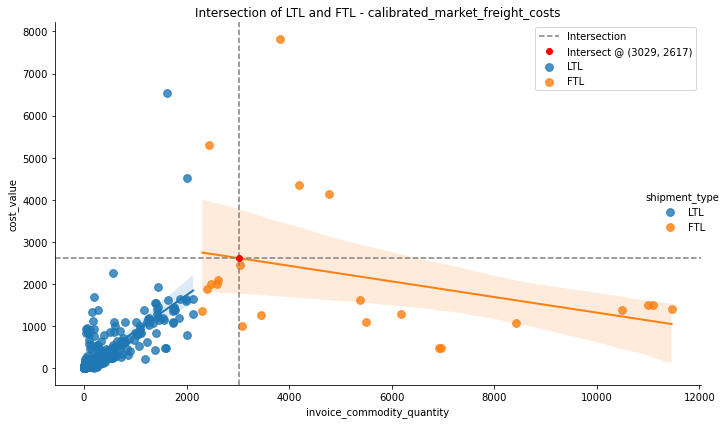

In [56]:

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Filter to one cost type for intersection analysis
selected_cost_type = 'calibrated_market_freight_costs'
subset = df_long[df_long['cost_type'] == selected_cost_type]

# Fit linear regression lines for LTL and FTL
coefs = {}
for ship_type in ['LTL', 'FTL']:
    temp = subset[subset['shipment_type'] == ship_type]
    slope, intercept = np.polyfit(temp['invoice_commodity_quantity'], temp['cost_value'], 1)
    coefs[ship_type] = (slope, intercept)

# Compute intersection point
m1, b1 = coefs['LTL']
m2, b2 = coefs['FTL']
x_intersect = (b2 - b1) / (m1 - m2)
y_intersect = m1 * x_intersect + b1

# Plot the selected cost type with intersection point
g = sns.lmplot(
    data=subset,
    x='invoice_commodity_quantity',
    y='cost_value',
    hue='shipment_type',
    height=6,
    aspect=1.5,
    scatter_kws={'s': 60},
    line_kws={'linewidth': 2}
)

plt.axvline(x=x_intersect, color='gray', linestyle='--', label='Intersection')
plt.axhline(y=y_intersect, color='gray', linestyle='--')
plt.plot(x_intersect, y_intersect, 'ro', label=f'Intersect @ ({x_intersect:.0f}, {y_intersect:.0f})')
plt.title(f'Intersection of LTL and FTL - {selected_cost_type}')
plt.legend()
plt.tight_layout()
plt.show()


In [57]:
df.columns

Index(['invoice_id', 'site', 'new_commodity_group',
       'invoice_commodity_quantity', 'multiple_commodities',
       'priority_multiple_commodities', 'freight_per_invoice',
       'standardization_status', 'error_summary', 'priority_failure_reasons',
       'method', 'unit', 'rate_unit', 'freight_class', 'rate', 'shipment_type',
       'invoice_freight_commodity_cost', 'raw_invoice_cost', 'minimum_applied',
       'calibrated_market_freight_costs', 'market_rate', 'xgs_applied_rate',
       'xgs_raw_rate', 'freight_ratio_raw', 'freight_ratio_normal',
       'rate_ratio_raw', 'rate_ratio_normal', 'market_cost_outlier',
       'freight_ratio_raw_outlier', 'freight_ratio_normal_outlier'],
      dtype='object')

In [58]:

# Prepare long-form DataFrame for 1VNL (weight-based) cost-type comparisons
df_long_vnl = df[df['new_commodity_group'] == '1VNL'].copy().melt(
    id_vars=['invoice_commodity_quantity', 'shipment_type'],
    value_vars=['calibrated_market_freight_costs', 'raw_invoice_cost', 'invoice_freight_commodity_cost'],
    var_name='cost_type',
    value_name='cost_value'
).dropna(subset=['cost_value'])

print("df_long_vnl preview:", df_long_vnl.head())


df_long_vnl preview:    invoice_commodity_quantity shipment_type                        cost_type  \
0                     1485.67           LTL  calibrated_market_freight_costs   
1                     6609.39           LTL  calibrated_market_freight_costs   
2                      121.16           LTL  calibrated_market_freight_costs   
3                     5725.44           LTL  calibrated_market_freight_costs   
4                       25.26           LTL  calibrated_market_freight_costs   

   cost_value  
0  147.023077  
1  463.592308  
2   45.484615  
3  296.446154  
4   92.369231  


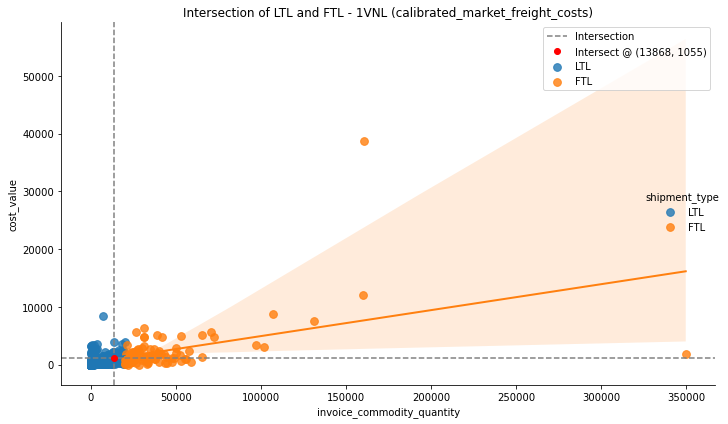

In [59]:

# Filter to one cost type for intersection analysis for 1VNL
selected_cost_type = 'calibrated_market_freight_costs'
subset_vnl = df_long_vnl[df_long_vnl['cost_type'] == selected_cost_type]

# Fit linear regression lines for LTL and FTL
coefs = {}
for ship_type in ['LTL', 'FTL']:
    temp = subset_vnl[subset_vnl['shipment_type'] == ship_type]
    slope, intercept = np.polyfit(temp['invoice_commodity_quantity'], temp['cost_value'], 1)
    coefs[ship_type] = (slope, intercept)

# Compute intersection point
m1, b1 = coefs['LTL']
m2, b2 = coefs['FTL']
x_intersect = (b2 - b1) / (m1 - m2)
y_intersect = m1 * x_intersect + b1

# Plot the selected cost type with intersection point
g = sns.lmplot(
    data=subset_vnl,
    x='invoice_commodity_quantity',
    y='cost_value',
    hue='shipment_type',
    height=6,
    aspect=1.5,
    scatter_kws={'s': 60},
    line_kws={'linewidth': 2}
)

plt.axvline(x=x_intersect, color='gray', linestyle='--', label='Intersection')
plt.axhline(y=y_intersect, color='gray', linestyle='--')
plt.plot(x_intersect, y_intersect, 'ro', label=f'Intersect @ ({x_intersect:.0f}, {y_intersect:.0f})')
plt.title(f'Intersection of LTL and FTL - 1VNL ({selected_cost_type})')
plt.legend()
plt.tight_layout()
plt.show()


In [60]:
# Prepare long-form DataFrame for 1VNL (weight-based) cost-type comparisons
df_long_cpt = df[df['new_commodity_group'] == '1CPT'].copy().melt(
    id_vars=['invoice_commodity_quantity', 'shipment_type'],
    value_vars=['calibrated_market_freight_costs', 'raw_invoice_cost', 'invoice_freight_commodity_cost'],
    var_name='cost_type',
    value_name='cost_value'
).dropna(subset=['cost_value'])

print("df_long_cpt preview:", df_long_vnl.head())

df_long_cpt preview:    invoice_commodity_quantity shipment_type                        cost_type  \
0                     1485.67           LTL  calibrated_market_freight_costs   
1                     6609.39           LTL  calibrated_market_freight_costs   
2                      121.16           LTL  calibrated_market_freight_costs   
3                     5725.44           LTL  calibrated_market_freight_costs   
4                       25.26           LTL  calibrated_market_freight_costs   

   cost_value  
0  147.023077  
1  463.592308  
2   45.484615  
3  296.446154  
4   92.369231  


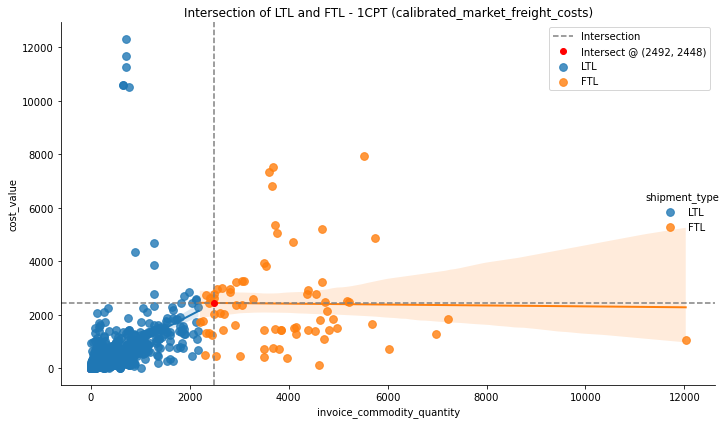

In [61]:

# Filter to one cost type for intersection analysis for 1VNL
selected_cost_type = 'calibrated_market_freight_costs'
subset_cpt = df_long_cpt[df_long_cpt['cost_type'] == selected_cost_type]

# Fit linear regression lines for LTL and FTL
coefs = {}
for ship_type in ['LTL', 'FTL']:
    temp = subset_cpt[subset_cpt['shipment_type'] == ship_type]
    slope, intercept = np.polyfit(temp['invoice_commodity_quantity'], temp['cost_value'], 1)
    coefs[ship_type] = (slope, intercept)

# Compute intersection point
m1, b1 = coefs['LTL']
m2, b2 = coefs['FTL']
x_intersect = (b2 - b1) / (m1 - m2)
y_intersect = m1 * x_intersect + b1

# Plot the selected cost type with intersection point
g = sns.lmplot(
    data=subset_cpt,
    x='invoice_commodity_quantity',
    y='cost_value',
    hue='shipment_type',
    height=6,
    aspect=1.5,
    scatter_kws={'s': 60},
    line_kws={'linewidth': 2}
)

plt.axvline(x=x_intersect, color='gray', linestyle='--', label='Intersection')
plt.axhline(y=y_intersect, color='gray', linestyle='--')
plt.plot(x_intersect, y_intersect, 'ro', label=f'Intersect @ ({x_intersect:.0f}, {y_intersect:.0f})')
plt.title(f'Intersection of LTL and FTL - 1CPT ({selected_cost_type})')
plt.legend()
plt.tight_layout()
plt.show()
